In [ ]:

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset , ConcatDataset,random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import torch
import skimage
from PIL import Image
from skimage import io
import pandas as pd
import os
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from sklearn.preprocessing import OneHotEncoder
import torchvision.models as models 
import scipy.io
#import torch.nn.functional as F
import copy

# **Data Loader Preparation**

In [ ]:

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
# testset67 = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)


# validation_B.data=trainset.data[0:3000]
# validation_B.targets=trainset.targets[0:3000]

trainset.data=trainset.data[3000:60000]
trainset.targets=trainset.targets[3000:60000]

# a= torch.tensor(range(0, 3000))
# b= list(range(5000, len(trainset)))
# validation_B= torch.utils.data.Subset(trainset, a)
# trainset_2 = torch.utils.data.Subset(trainset, b)


# Filtering 0-5 digits
idx = (trainset.targets >= 0) & (trainset.targets <= 5)
subset05 = torch.utils.data.Subset(trainset, np.where(idx)[0])
# Filtering 6-7 digits
idx = (trainset.targets >= 6) & (trainset.targets <= 7)
subset67 = torch.utils.data.Subset(trainset, np.where(idx)[0])

idx = (testset.targets >= 0) & (testset.targets <= 5)
testset05 = torch.utils.data.Subset(testset, np.where(idx)[0])
# testset05.targets = testset.targets[idx]
# testset05.data = testset.data[idx]

idx = (testset.targets >= 6) & (testset.targets <= 7)
testset67 = torch.utils.data.Subset(testset, np.where(idx)[0])
# testset67.targets = testset.targets[idx]
# testset67.data = testset.data[idx]

#creating combined data to pass it to dataloader
combinedtestset = torch.utils.data.ConcatDataset([testset05, testset67])

# Define the dataloaders
trainloader05 = DataLoader(subset05, batch_size=64, shuffle=True)
trainloader67 = DataLoader(subset67, batch_size=64, shuffle=True)
# valloader = DataLoader(valset, batch_size=64, shuffle=True)
testloader = DataLoader(testset05, batch_size=64, shuffle=True)
testloader67 = DataLoader(testset67, batch_size=64, shuffle=True)
Combined_testloader = DataLoader(combinedtestset, batch_size=64, shuffle=True)


# For reproducibility
torch.manual_seed(0)

# Sample 100 samples per class from 0-5 digits
indices = []
for target in range(6):
    target_indices = np.where(trainset.targets == target)[0]
    indices += target_indices[torch.randperm(len(target_indices))[:20]].tolist()

exemplars = torch.utils.data.Subset(trainset, indices)
combinedset = torch.utils.data.ConcatDataset([subset67, exemplars])
#  dataloader for continual learning
continualloader = DataLoader(combinedset, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 330256902.86it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29748451.33it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 102987080.20it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21477484.52it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [ ]:
validation= datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)


In [ ]:
validation.data=validation.data[0:3000]
validation.targets=validation.targets[0:3000]

In [ ]:
idx = (validation.targets >= 0) & (validation.targets <= 7)
validation_B = torch.utils.data.Subset(validation, np.where(idx)[0])
validation_Loader= DataLoader(validation_B, batch_size=1, shuffle=True)

# **Custom Vgg Class**

In [ ]:
class custom_vgg(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 =nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.layer4 =nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*256, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 6))

        
    def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out

# **Training Function for simple model**

In [ ]:
def train_simple(model,dataloader,loss_function,optimizer):
  running_loss = 0
  training_loss =[]
  training_accuracy=[]
  validation_loss=[]
  validation_accuracy=[]
  epochs = 2
  training_epoch_loss=[]
  training_epoch_accuracy=[]
  validation_epoch_loss=[]
  validation_epoch_accuracy=[]

  for epoch in range(epochs):
      t_loss = 0
      t_correct = 0
      t_total=0
      v_loss = 0
      v_correct=0
      v_total=0
      
      
      for i, data in enumerate(dataloader, 0):
          inputs, labels = data

          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          

          loss_i = loss_function(outputs, labels)
        
          loss_i.backward()
          optimizer.step()
          t_loss += loss_i.item() * inputs.size(0) 
          _, predicted = torch.max(outputs.data, 1)
          t_total += labels.size(0)
          t_correct += (predicted == labels).sum().item()
          
          training_loss.append(t_loss / t_total)
          training_accuracy.append(t_correct / t_total)
  return model,training_loss,training_accuracy
        
                    

## Prediction

In [ ]:
def prediction(model,dataloader):
  actual=[]
  predict=[]
  t_total=0
  t_correct=0

  model.eval()
  with torch.no_grad():
      for i, data in enumerate(dataloader, 0):
          inputs, labels = data
          outputs = model(inputs)
          _,predicted = torch.max(outputs.data,1)
          t_total += labels.size(0)
          t_correct += (predicted==labels).sum().item()
          predict.extend(predicted.numpy())
          actual.extend(labels.numpy())
          acc=(100 * t_correct / t_total)
 
  return predict,actual,acc

# **Train Model with distillation loss**

In [ ]:
def train_incremental(student_model,teacher_model,dataloader,loss_incr,optimizer):
  running_loss = 0
 

  training_loss =[]
  training_accuracy=[]
  validation_loss=[]
  validation_accuracy=[]
  epochs = 2
  training_epoch_loss=[]
  training_epoch_accuracy=[]
  validation_epoch_loss=[]
  validation_epoch_accuracy=[]
  temperature=3
  alpha=0.75
  for epoch in range(epochs):
      t_loss = 0
      t_correct = 0
      t_total=0
      v_loss = 0
      v_correct=0
      v_total=0
      
      
      for i, data in enumerate(dataloader, 0):
          inputs, labels = data

          inputs = inputs.to(device)
          labels = labels.to(device)
          
          optimizer.zero_grad()
          # Forward pass through the teacher model
          with torch.no_grad():
              teacher_outputs = teacher_model(inputs)
          
          # Forward pass through the student model
          student_outputs = student_model(inputs)

          # Compute the distillation loss

          soft_teacher_outputs = nn.functional.softmax(teacher_outputs / temperature, dim=1)
          soft_student_outputs = nn.functional.log_softmax(student_outputs[:,:6] / temperature, dim=1)

          #computing distillation loss using teacher and student model
          distillation_loss = loss_incr(soft_student_outputs, soft_teacher_outputs)
          #computing cross entropy loss for student model
          cross_entropy_loss = loss_incr(student_outputs, labels)

          # Total loss
          total_loss = distillation_loss * alpha + cross_entropy_loss*(1-alpha)

          # Backward pass and optimization
          total_loss.backward()
          optimizer.step()
  return student_model

# Moving model to GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)
# Then, transfer the model to the GPU

Device being used: cuda:0


## **Training On Old Classes and acc on Test Data**

In [ ]:
vgg16_teacher = custom_vgg()
vgg16_teacher=vgg16_teacher.to(device)
loss_teacher= torch.nn.CrossEntropyLoss()
optimizer_teacher = torch.optim.SGD(vgg16_teacher.parameters(), lr=0.001, momentum=0.91)

Model Accuracy on Target Test Data= 99.60205604377383


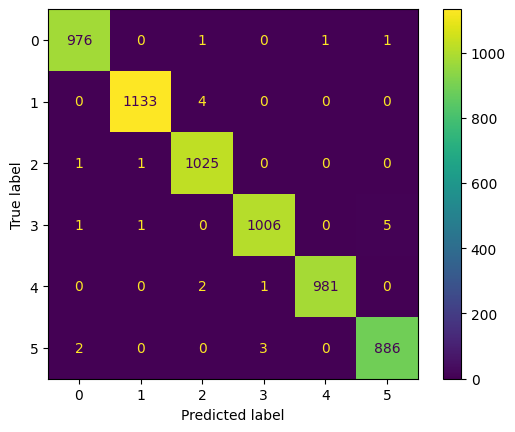

In [ ]:
vgg16_teacher,training_loss,training_accuracy = train_simple(vgg16_teacher,trainloader05,loss_teacher,optimizer_teacher)
vgg16_teacher = vgg16_teacher.cpu()
predict,actual,acc = prediction(vgg16_teacher,testloader)
print("Model Accuracy on Target Test Data=",acc)
cm = confusion_matrix(predict, actual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## **Training Model with new classes and some examplars from lod classes**

In [ ]:
vgg16_student = copy.deepcopy(vgg16_teacher)
#adding extra 2 last layer logits
vgg16_student.fc2=nn.Sequential(nn.Linear(4096, 8))

vgg16_student=vgg16_student.to(device)
loss_teacher= torch.nn.CrossEntropyLoss()
optimizer_student = torch.optim.SGD(vgg16_student.parameters(), lr=0.001, momentum=0.91)

Model Accuracy on Target Test Data= 68.79456143259824


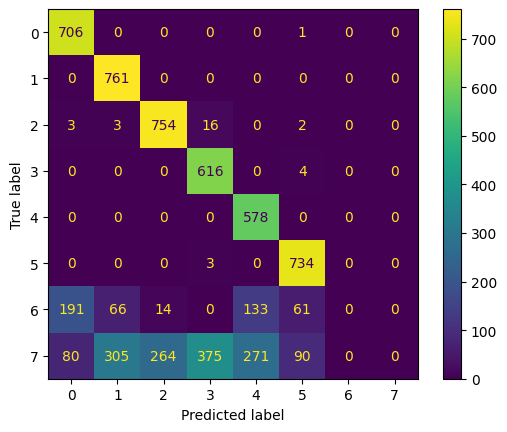

In [ ]:
vgg16_student,training_loss,training_accuracy = train_simple(vgg16_student,continualloader,loss_teacher,optimizer_student)
vgg16_student = vgg16_student.cpu()
predict_s,actual_s,acc_student = prediction(vgg16_student,testloader)
print("Model Accuracy on Target Test Data=",acc_student)
cm = confusion_matrix(predict_s, actual_s)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Model Accuracy on Target Test Data= 99.8489425981873


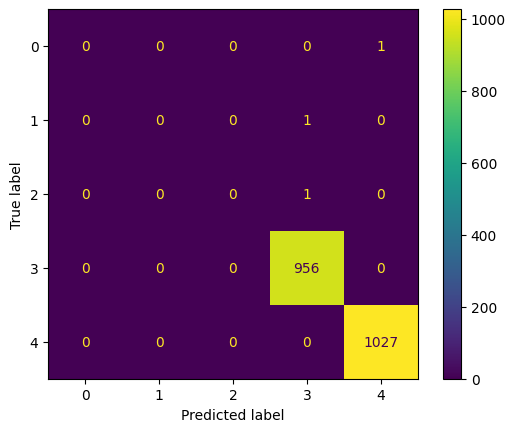

In [ ]:
predict_s,actual_s,acc_student = prediction(vgg16_student,testloader67)
print("Model Accuracy on Target Test Data=",acc_student)
cm = confusion_matrix(predict_s, actual_s)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Training model With incremental learning with 6,7 digits Class

In [ ]:
vgg16_incremental = copy.deepcopy(vgg16_teacher)
vgg16_incremental.fc2=nn.Sequential(nn.Linear(4096, 8))
vgg16_teacher=vgg16_teacher.to(device)
vgg16_incremental=vgg16_incremental.to(device)
loss_teacher= torch.nn.CrossEntropyLoss()
# optimizing student's model only
optimizer = optim.SGD(vgg16_incremental.parameters(), lr=0.01)  



Model Accuracy on Target Test Data= 85.86753149557191


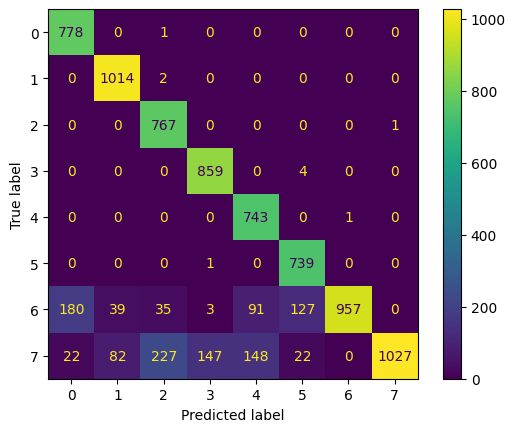

In [ ]:
 model_incremental = train_incremental(vgg16_incremental,vgg16_teacher,continualloader,loss_teacher,optimizer)
 model_incremental = model_incremental.cpu()
predict_incr,actual_incr,acc_incremental = prediction(model_incremental,Combined_testloader)
print("Model Accuracy on Target Test Data=",acc_incremental)
cm = confusion_matrix(predict_incr, actual_incr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Model Accuracy on Target Test Data= 99.8992950654582


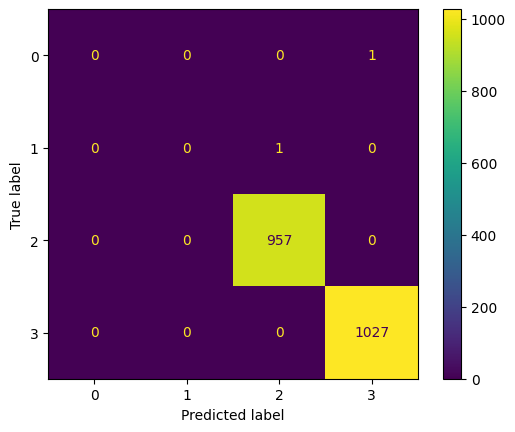

In [ ]:
predict_incremental,actual_incremental,accuracy_incremental = prediction(model_incremental,testloader67)
print("Model Accuracy on Target Test Data=",accuracy_incremental)
cm = confusion_matrix(predict_incremental, actual_incremental)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 model_save_name = 'model_incremental.pt'
 path = f"/content/drive/My Drive/{model_save_name}" 
 torch.save(model_incremental.state_dict(), path)

## Bias Correction Implemetation


In [ ]:
import torch
import torch.nn as nn

class LinearLayer(nn.Module):
    def __init__(self):
        super(LinearLayer, self).__init__()

        #defining weight and bias 
        self.weight = nn.Parameter(torch.randn(1))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        # here we are multipling weights with input and adding bias in that
        output = x * self.weight + self.bias
        return output




In [ ]:
class custom_vgg_bias(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 =nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.layer4 =nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*256, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 8))
        self.fc3_I= nn.Sequential(
            nn.Identity(6, 6))
        # self.fc3_F=nn.Sequential(
        #     linear_layer(2))
        
        #     nn.LinearLayer())
        self.fc3_F=LinearLayer()

        
    def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)

            replicated_neurons = out[:, :6]
            fully_connected_neurons = out[:, -2:]

            replicated_output = self.fc3_I(replicated_neurons)
            fully_connected_output = self.fc3_F(fully_connected_neurons)
            out=torch.cat((replicated_output, fully_connected_output), dim=1)


            return out

In [ ]:
F_model=custom_vgg_bias()

In [ ]:
F_model.load_state_dict(torch.load('/content/drive/MyDrive/model_incremental.pt'),strict=False)

_IncompatibleKeys(missing_keys=['fc3_F.weight', 'fc3_F.bias'], unexpected_keys=[])

In [ ]:
for param in F_model.parameters():
    param.requires_grad = False

In [ ]:
F_model

custom_vgg_bias(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
for param in F_model.fc3_F.parameters():
    param.requires_grad = True

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(F_model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| fc3_F.weight |     1      |
|  fc3_F.bias  |     1      |
+--------------+------------+
Total Trainable Params: 2


2

In [ ]:
F_model.to(device)
loss= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(F_model.parameters(), lr=0.01, momentum=0.91)

In [ ]:
next(iter(validation_Loader))

[tensor([[[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -

Model Accuracy on Target Test Data= 97.23088437071223


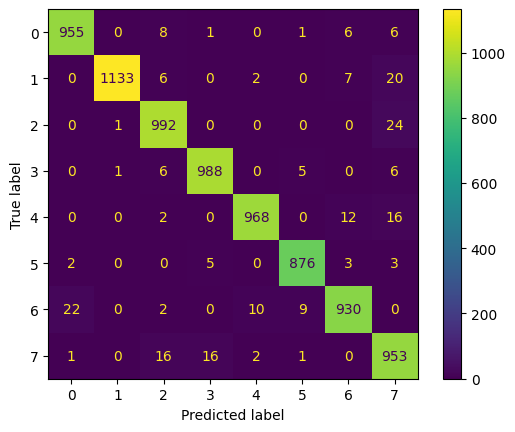

In [ ]:
model,training_loss,training_accuracy = train_simple(F_model,validation_Loader,loss,optimizer)
model.cpu()
predict,actual,acc = prediction(model,Combined_testloader)
print("Model Accuracy on Target Test Data=",acc)
cm = confusion_matrix(predict, actual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Model Accuracy on Target Test Data= 94.81369587109768


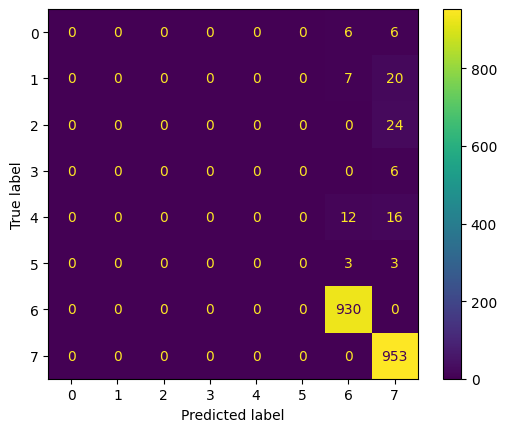

In [ ]:
predict,actual,acc = prediction(model,testloader67)
print("Model Accuracy on Target Test Data=",acc)
cm = confusion_matrix(predict, actual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
vgg16_incremental

custom_vgg(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

Model Accuracy on Target Test Data= 85.86753149557191


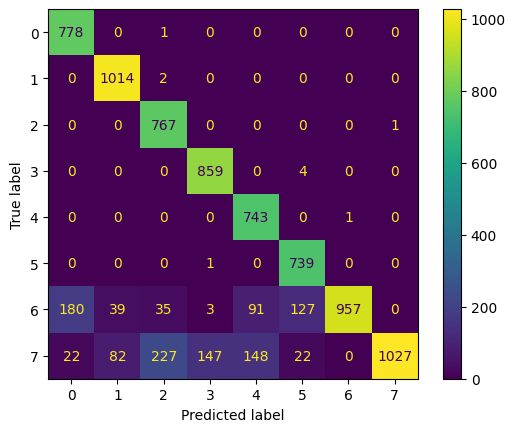

In [ ]:
predict,actual,acc = prediction(vgg16_incremental,Combined_testloader)
print("Model Accuracy on Target Test Data=",acc)
cm = confusion_matrix(predict, actual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()